In [2]:
import pennylane as qml 
from einops import rearrange 
import torch 
from matplotlib import pyplot as plt    
from torch import nn 

class Q_Conv2d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int, padding: int=0, num_layers: int=0, num_qubits: int=0):
        super().__init__()
        if num_qubits == 0:
            num_qubits = kernel_size**2 * in_channels
        if num_layers == 0:
            num_layers = kernel_size**2
        assert num_qubits == kernel_size**2 * in_channels, "The kernel size must be a square of the number of qubits"
        dev = qml.device("default.qubit", wires=num_qubits)
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.num_qubits = num_qubits
        self.num_layers = num_layers
        self.in_channels = in_channels
        self.out_channels = out_channels

        @qml.qnode(dev)
        def qnode(inputs, weights):
            qml.AngleEmbedding(inputs, wires=range(num_qubits))
            qml.BasicEntanglerLayers(weights, wires=range(num_qubits))
            return [qml.expval(qml.PauliZ(wires=list(range(num_qubits))[-1]))]

        weight_shapes = {"weights": (num_layers, num_qubits)}

        self.qlayer_list = nn.ModuleList([qml.qnn.TorchLayer(qnode, weight_shapes) for _ in range(self.out_channels)])
        fig, ax = qml.draw_mpl(qnode ,expansion_strategy='device')(torch.randn(num_qubits),
                            torch.randn(num_layers, num_qubits))
        fig.savefig('./model.png')


    def forward(self, x):
        assert len(x.shape) == 4, "The input tensor must be 4D"
        assert x.shape[1] == self.in_channels, "The number of input channels must be equal to the in_channels"
        res = list()
        x = x.unfold(2, self.kernel_size, self.stride)
        x = x.unfold(3, self.kernel_size, self.stride)
        x = rearrange(x, 'b c h w i j -> b h w (c i j)')    
        bs, h, w, _ = x.shape
        for i in range(self.out_channels):
            res.append(self.qlayer_list[i](x).view(bs, h, w))        
        x = torch.stack(res, dim=1)
        return x



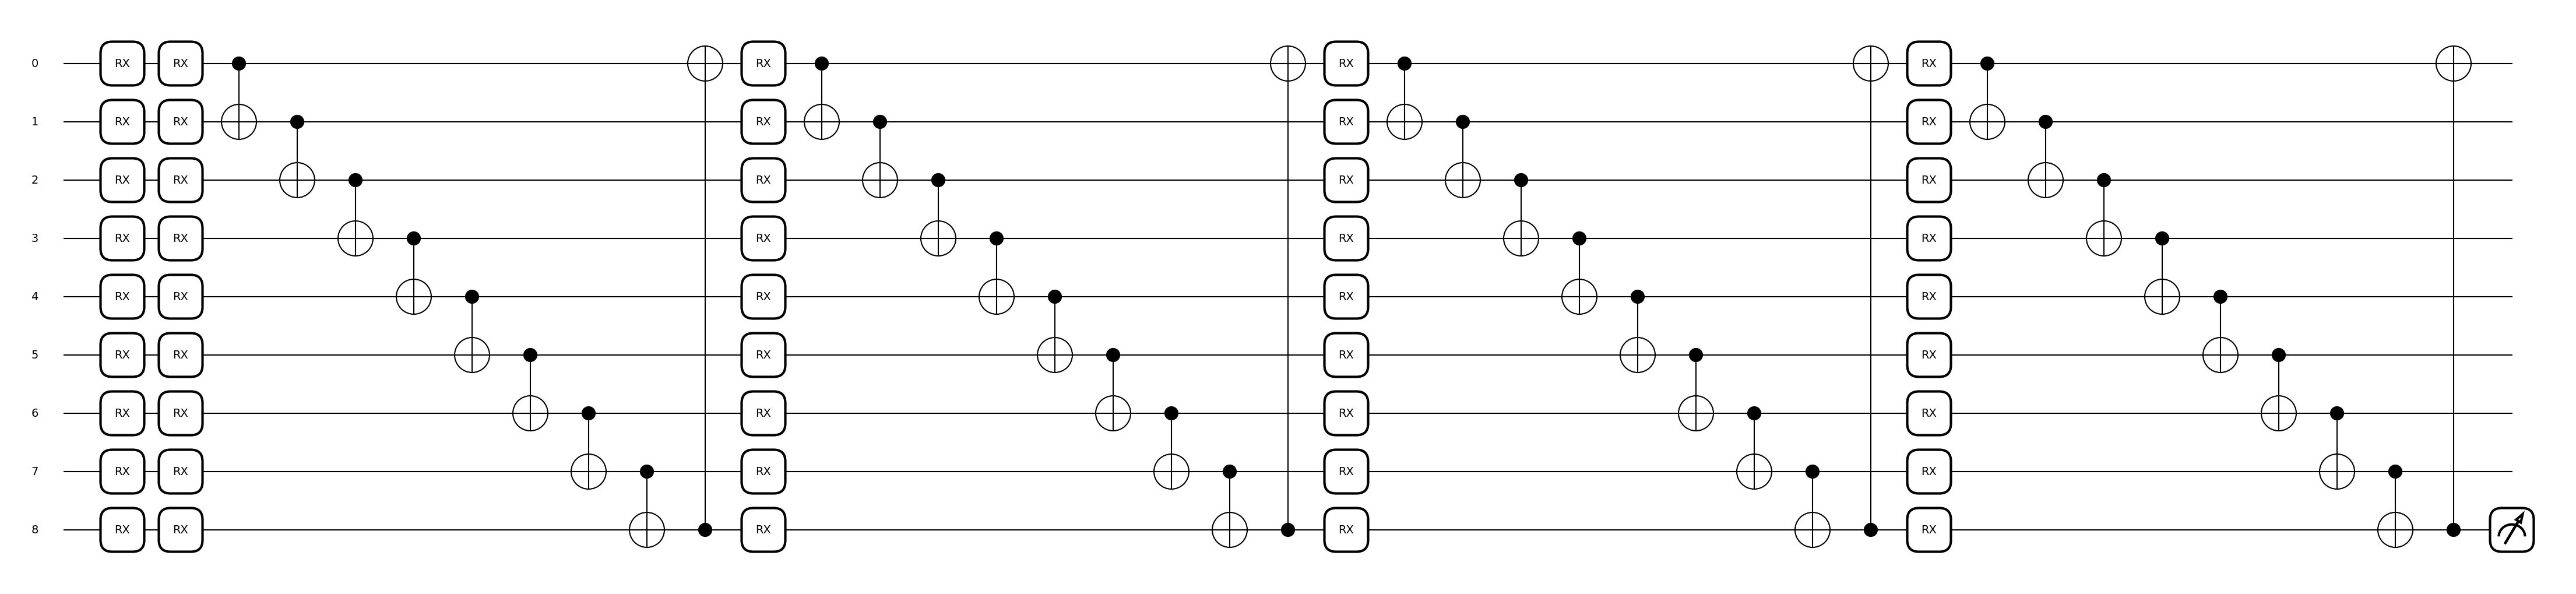

In [10]:
model = Q_Conv2d(1, 1, 3, 2, num_layers=4),
